<a href="https://colab.research.google.com/github/DevEnriquegd/ca-telecom-x-2/blob/main/ca_telecom_x_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge Alura: Telecom X - Parte 2

Tu nueva misión es desarrollar modelos predictivos capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios.

La empresa quiere anticiparse al problema de la cancelación, y te corresponde a ti construir un pipeline robusto para esta etapa inicial de modelado.

## 🛠️ Preparación de los Datos

### Extracción del Archivo Tratado

Carga el archivo CSV que contiene los datos tratados anteriormente.
📂 Atención: Utiliza el mismo archivo que limpiaste y organizaste en la Parte 1 del desafío Telecom X. Debe contener solo las columnas relevantes, ya con los datos corregidos y estandarizados.

In [ ]:
import pandas as pd

url = 'https://raw.githubusercontent.com/DevEnriquegd/ca-telecom-x/refs/heads/main/data/telecom_x_data_lista.csv'

data = pd.read_csv(url)

In [ ]:
data.columns.tolist()

['customer_id',
 'churn',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'contract',
 'paperless_billing',
 'payment_method',
 'charges_daily',
 'charges_monthly',
 'charges_total',
 'charges_monthly_seg',
 'charges_total_seg',
 'tenure_seg']

In [ ]:
data.sample(2)

,customer_id,churn,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,...,streaming_movies,contract,paperless_billing,payment_method,charges_daily,charges_monthly,charges_total,charges_monthly_seg,charges_total_seg,tenure_seg
155,0256-LTHVJ,1,Female,0,1,1,28,1,0,Fiber optic,...,1,Month-to-month,1,Electronic check,2.70,81.05,2227.10,Medio-alto,Medio-alto,Intermedio
1529,2236-HILPA,0,Male,0,1,1,62,1,0,No,...,No internet service,Two year,0,Credit card (automatic),0.69,20.65,1218.45,Bajo,Medio-bajo,Muy leal


### Eliminación de Columnas Irrelevantes

Elimina columnas que no aportan valor al análisis o a los modelos predictivos, como identificadores únicos (por ejemplo, el ID del cliente). Estas columnas no ayudan en la predicción de la cancelación y pueden incluso perjudicar el desempeño de los modelos.



In [ ]:
columnas_irrelevantes = [
    'customer_id',
    'charges_monthly_seg',
    'charges_total_seg',
    'tenure_seg',
    'charges_daily'
]

data = data.drop(columns=columnas_irrelevantes)

data.columns

Index(['churn', 'gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'charges_monthly', 'charges_total'],
      dtype='object')

### Encoding

Transforma las variables categóricas a formato numérico para hacerlas compatibles con los algoritmos de machine learning. Utiliza un método de codificación adecuado, como one-hot encoding.

In [ ]:
servicios_adicionales = [
    'online_security', 'online_backup', 'device_protection',
    'tech_support', 'streaming_tv', 'streaming_movies'
]

for col in servicios_adicionales:
    data[col] = data[col].apply(lambda x: 1 if x == '1' else 0)

data['gender'] = data['gender'].map({'Male': 1, 'Female': 0})

data['multiple_lines'] = data['multiple_lines'].apply(lambda x: 1 if str(x) == '1' else 0)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

variables_multiclase = ['internet_service', 'contract', 'payment_method']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), variables_multiclase)
    ],
    remainder='passthrough'
)

data_transformada = preprocessor.fit_transform(data)

columnas_finales = preprocessor.get_feature_names_out()

data_encoded = pd.DataFrame(
    data_transformada,
    columns=columnas_finales,
    index=data.index
)

print(f"Encoding aplicado correctamente. Total columnas: {data_encoded.shape[1]}")

Encoding aplicado correctamente. Total columnas: 24


In [ ]:
data_encoded.sample(4)

,cat__internet_service_Fiber optic,cat__internet_service_No,cat__contract_One year,cat__contract_Two year,cat__payment_method_Credit card (automatic),cat__payment_method_Electronic check,cat__payment_method_Mailed check,remainder__churn,remainder__gender,remainder__senior_citizen,...,remainder__multiple_lines,remainder__online_security,remainder__online_backup,remainder__device_protection,remainder__tech_support,remainder__streaming_tv,remainder__streaming_movies,remainder__paperless_billing,remainder__charges_monthly,remainder__charges_total
4609,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,94.70,673.10
1670,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,54.45,1127.35
357,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,85.00,2624.25
1164,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.75,948.90


### Verificación de la Proporción de Cancelación (Churn)

Calcula la proporción de clientes que cancelaron en relación con los que permanecieron activos. Evalúa si existe un desbalance entre las clases, ya que esto puede impactar en los modelos predictivos y en el análisis de los resultados.

In [ ]:
distribucion = data['churn'].value_counts().to_frame()
distribucion.columns = ['Cantidad']
distribucion['Proporción'] =round( data['churn'].value_counts(normalize=True),2)

distribucion

,Cantidad,Proporción
churn,,
0,5174,0.73
1,1869,0.27


## 🎯 Correlación y Selección de Variables

### Análisis de Correlación

Visualiza la matriz de correlación para identificar relaciones entre las variables numéricas. Presta especial atención a las variables que muestran una mayor correlación con la cancelación, ya que estas pueden ser fuertes candidatas para el modelo predictivo.




In [ ]:
corr_matrix = data_encoded.corr()

corr_churn = (
    corr_matrix["remainder__churn"]
    .sort_values(ascending=False)
    .to_frame()
)

corr_churn

,remainder__churn
remainder__churn,1.000000
cat__internet_service_Fiber optic,0.308020
cat__payment_method_Electronic check,0.301919
remainder__charges_monthly,0.193356
remainder__paperless_billing,0.191825
remainder__senior_citizen,0.150889
remainder__streaming_tv,0.063228
remainder__streaming_movies,0.061382
remainder__multiple_lines,0.040102
remainder__phone_service,0.011942


### Análisis Dirigido

Investiga cómo variables específicas se relacionan con la cancelación, tales como:

* Tiempo de contrato × Cancelación

* Gasto total × Cancelación

Utiliza gráficos como boxplots o scatter plots para visualizar patrones y posibles tendencias.

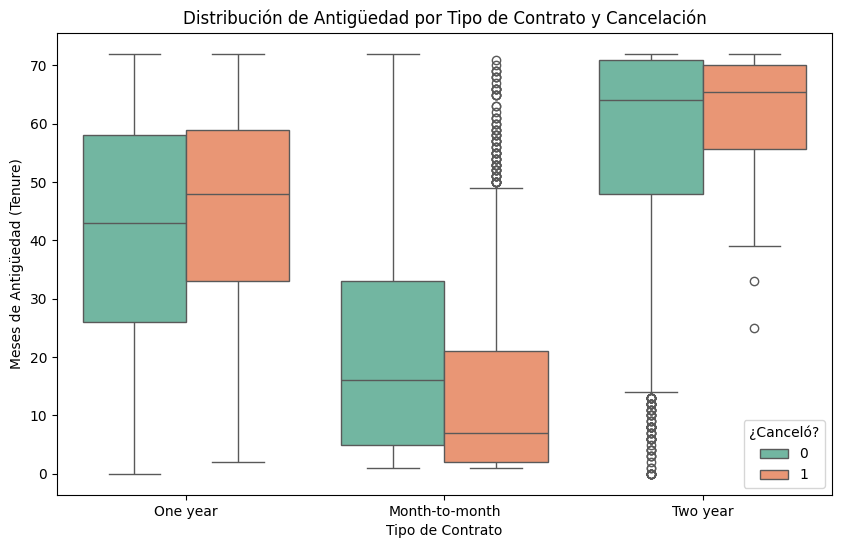

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='contract', y='tenure', hue='churn', data=data, palette='Set2')

plt.title('Distribución de Antigüedad por Tipo de Contrato y Cancelación')
plt.xlabel('Tipo de Contrato')
plt.ylabel('Meses de Antigüedad (Tenure)')
plt.legend(title='¿Canceló?')
plt.show()

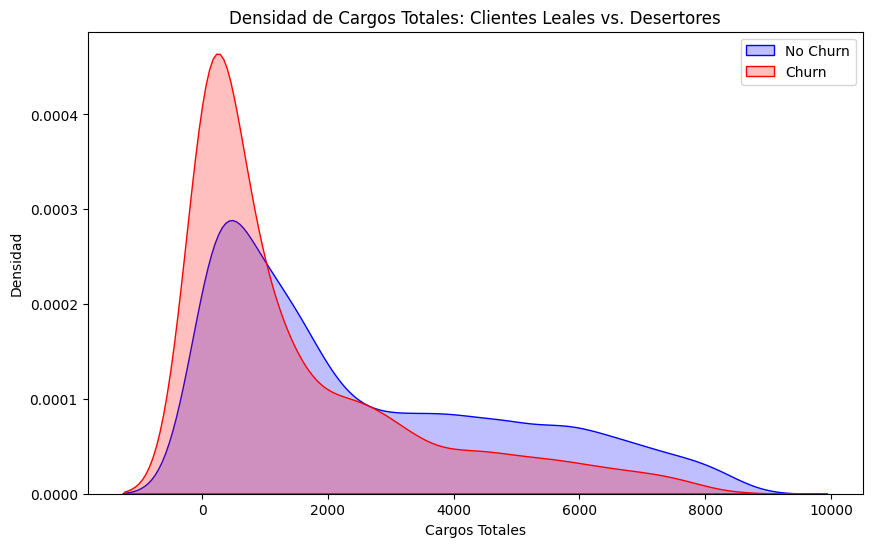

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data[data['churn'] == 0], x='charges_total', fill=True, label='No Churn', color='blue')
sns.kdeplot(data=data[data['churn'] == 1], x='charges_total', fill=True, label='Churn', color='red')

plt.title('Densidad de Cargos Totales: Clientes Leales vs. Desertores')
plt.xlabel('Cargos Totales')
plt.ylabel('Densidad')
plt.legend()
plt.show()

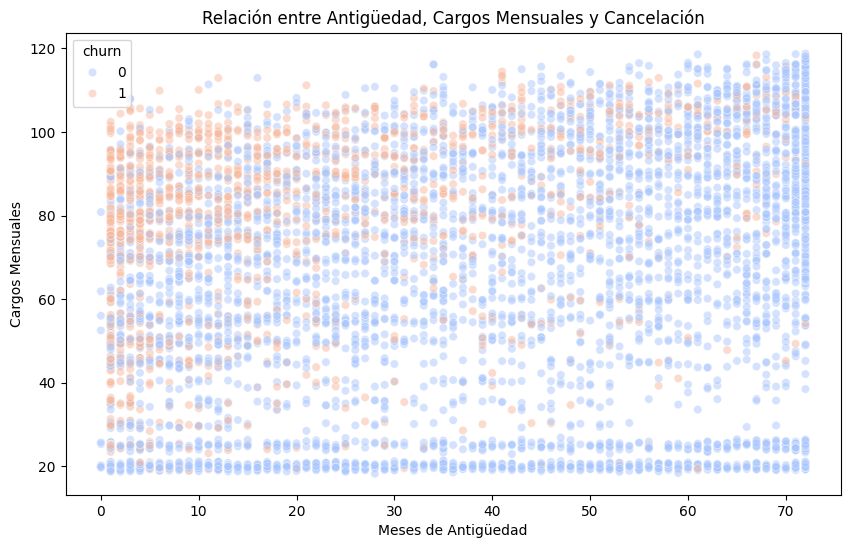

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tenure', y='charges_monthly', hue='churn', data=data, alpha=0.5, palette='coolwarm')

plt.title('Relación entre Antigüedad, Cargos Mensuales y Cancelación')
plt.xlabel('Meses de Antigüedad')
plt.ylabel('Cargos Mensuales')
plt.show()

## 🤖 Modelado Predictivo

### Separación de Datos

Divide el conjunto de datos en entrenamiento y prueba para evaluar el rendimiento del modelo. Una división común es 70% para entrenamiento y 30% para prueba, o 80/20, dependiendo del tamaño de la base de datos.

In [ ]:
from sklearn.model_selection import train_test_split

X = data_encoded.drop('remainder__churn', axis=1)
y = data_encoded['remainder__churn']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

### Creación de Modelos

Crea al menos dos modelos diferentes para predecir la cancelación de clientes.

* Un modelo puede requerir normalización, como Regresión Logística o KNN.

* El otro modelo puede no requerir normalización, como Árbol de Decisión o Random Forest.

💡 La decisión de aplicar o no la normalización depende de los modelos seleccionados. Ambos modelos pueden ser creados sin normalización, pero también es una opción combinar modelos con y sin normalización.

Justificación:

* Regresión Logística / KNN: Estos modelos son sensibles a la escala de los datos, por lo que la normalización es importante para que los coeficientes o las distancias se calculen correctamente.

* Árbol de Decisión / Random Forest: Estos modelos no dependen de la escala de los datos, por lo que no es necesario aplicar normalización.

Si decides normalizar los datos, deberías explicar cómo esta etapa asegura que los modelos basados en distancia o en optimización de parámetros no se vean sesgados por la magnitud de las variables.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

modelo_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

modelo_knn.fit(X_train, y_train)

y_pred_knn = modelo_knn.predict(X_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

modelo_tree = DecisionTreeClassifier(random_state=42, max_depth=5)

modelo_tree.fit(X_train, y_train)

y_pred_tree = modelo_tree.predict(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

modelo_rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)

modelo_rf.fit(X_train, y_train)

y_pred_rf = modelo_rf.predict(X_test)

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores_knn = cross_val_score(
    modelo_knn,
    X_train,
    y_train,
    cv=skf,
    scoring='recall'
)

scores_tree = cross_val_score(
    modelo_tree,
    X_train,
    y_train,
    cv=skf,
    scoring='recall'
)

scores_rf = cross_val_score(
    modelo_rf,
    X_train,
    y_train,
    cv=skf,
    scoring='recall'
)

print(f"KNN - Recall Promedio: {scores_knn.mean():.4f} (+/- {scores_knn.std():.4f})")
print(f"Árbol - Recall Promedio: {scores_tree.mean():.4f} (+/- {scores_tree.std():.4f})")
print(f"RF - Recall Promedio: {scores_rf.mean():.4f} (+/- {scores_rf.std():.4f})")

KNN - Recall Promedio: 0.5397 (+/- 0.0194)
Árbol - Recall Promedio: 0.4595 (+/- 0.0410)
RF - Recall Promedio: 0.5099 (+/- 0.0191)


### Evaluación de los Modelos

Evalúa cada modelo utilizando las siguientes métricas:

* Exactitud (Acurácia)
* Precisión
* Recall
* F1-score
* Matriz de confusión

Después, realiza un análisis crítico y compara los modelos:

¿Cuál modelo tuvo el mejor desempeño?

¿Algún modelo presentó overfitting o underfitting? Si es así, considera las posibles causas y ajustes:

* Overfitting: Cuando el modelo aprende demasiado sobre los datos de entrenamiento, perdiendo la capacidad de generalizar a nuevos datos. Considera reducir la complejidad del modelo o aumentar los datos de entrenamiento.

* Underfitting: Cuando el modelo no captura bien las tendencias de los datos, lo que indica que es demasiado simple. Intenta aumentar la complejidad del modelo o ajustar sus parámetros

In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score
)
import matplotlib.pyplot as plt
import numpy as np

def evaluar_modelo(modelo, X_train, y_train, X_test, y_test, nombre_modelo):

    modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]

    print(f"\n{'='*60}")
    print(f"MODELO: {nombre_modelo}")
    print(f"{'='*60}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    roc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {roc:.4f}")

    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["No Churn", "Churn"]
    )

    disp.plot()
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    tn, fp, fn, tp = cm.ravel()

    print("\nResumen Estratégico:")
    print(f"Clientes que se iban y fueron detectados (TP): {tp}")
    print(f"Clientes que se iban y NO fueron detectados (FN): {fn}")

    return {
        "modelo": nombre_modelo,
        "recall_churn": tp / (tp + fn),
        "precision_churn": tp / (tp + fp) if (tp + fp) > 0 else 0,
        "roc_auc": roc
    }


MODELO: KNN

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.83      0.83      1552
         1.0       0.52      0.50      0.51       561

    accuracy                           0.75      2113
   macro avg       0.67      0.67      0.67      2113
weighted avg       0.74      0.75      0.74      2113

ROC-AUC: 0.7649


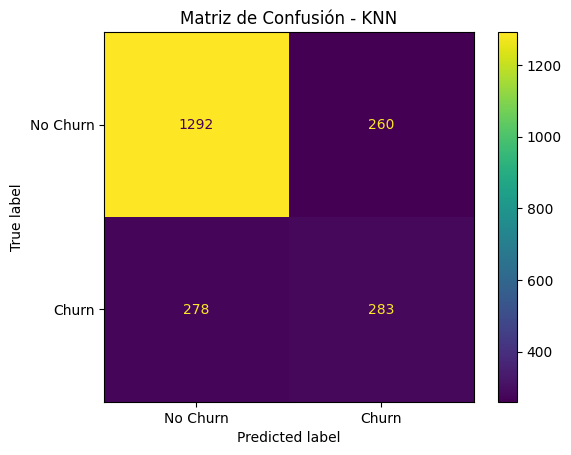


Resumen Estratégico:
Clientes que se iban y fueron detectados (TP): 283
Clientes que se iban y NO fueron detectados (FN): 278

MODELO: DecisionTree

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      1552
         1.0       0.59      0.62      0.60       561

    accuracy                           0.78      2113
   macro avg       0.72      0.73      0.73      2113
weighted avg       0.79      0.78      0.79      2113

ROC-AUC: 0.8257


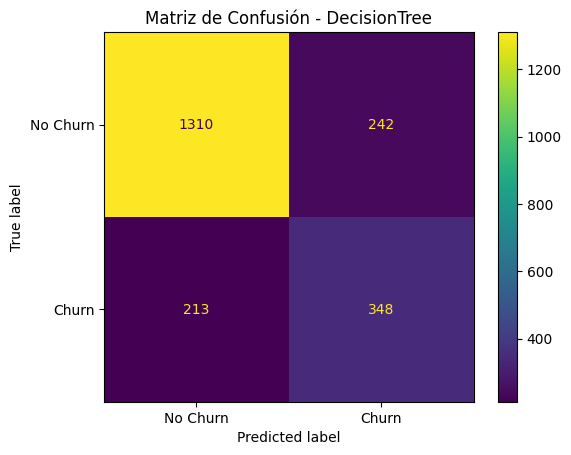


Resumen Estratégico:
Clientes que se iban y fueron detectados (TP): 348
Clientes que se iban y NO fueron detectados (FN): 213

MODELO: RandomForest

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87      1552
         1.0       0.64      0.51      0.57       561

    accuracy                           0.80      2113
   macro avg       0.74      0.71      0.72      2113
weighted avg       0.78      0.80      0.79      2113

ROC-AUC: 0.8374


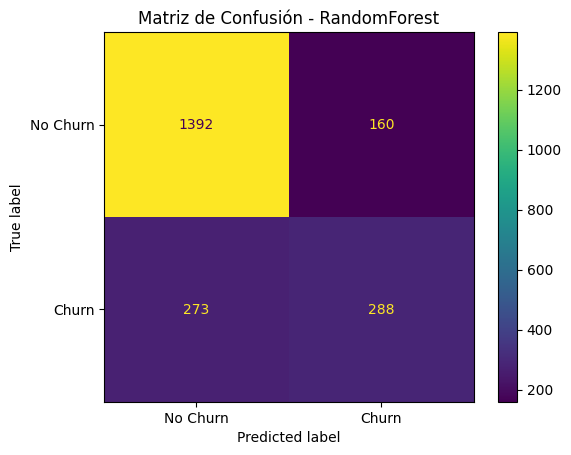


Resumen Estratégico:
Clientes que se iban y fueron detectados (TP): 288
Clientes que se iban y NO fueron detectados (FN): 273


,modelo,recall_churn,precision_churn,roc_auc
0,KNN,0.504456,0.521179,0.764863
1,DecisionTree,0.620321,0.589831,0.825698
2,RandomForest,0.513369,0.642857,0.837378


In [ ]:
resultados = []

resultados.append(
    evaluar_modelo(modelo_knn, X_train, y_train, X_test, y_test, "KNN")
)

resultados.append(
    evaluar_modelo(modelo_tree, X_train, y_train, X_test, y_test, "DecisionTree")
)

resultados.append(
    evaluar_modelo(modelo_rf, X_train, y_train, X_test, y_test, "RandomForest")
)


pd.DataFrame(resultados)

### Balanceo de Clases (opcional)

Si deseas profundizar en el análisis, aplica técnicas de balanceo como undersampling o oversampling. En situaciones de fuerte desbalanceo, herramientas como SMOTE pueden ser útiles para generar ejemplos sintéticos de la clase minoritaria.


MODELO: KNN + SMOTE

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.68      0.76      1552
         1.0       0.44      0.70      0.54       561

    accuracy                           0.69      2113
   macro avg       0.65      0.69      0.65      2113
weighted avg       0.75      0.69      0.70      2113

ROC-AUC: 0.7545


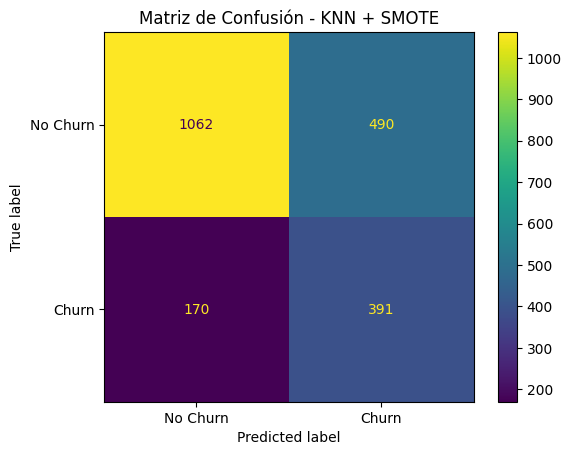


Resumen Estratégico:
Clientes que se iban y fueron detectados (TP): 391
Clientes que se iban y NO fueron detectados (FN): 170

MODELO: KNN + Undersampling

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.68      0.77      1552
         1.0       0.46      0.77      0.58       561

    accuracy                           0.70      2113
   macro avg       0.68      0.72      0.67      2113
weighted avg       0.78      0.70      0.72      2113

ROC-AUC: 0.7842


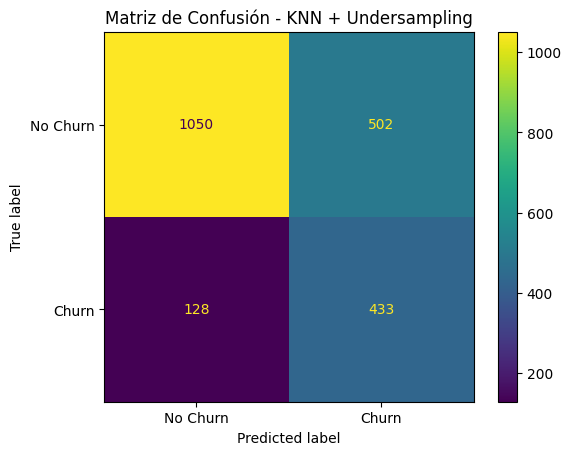


Resumen Estratégico:
Clientes que se iban y fueron detectados (TP): 433
Clientes que se iban y NO fueron detectados (FN): 128

MODELO: RandomForest + SMOTE

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85      1552
         1.0       0.58      0.59      0.59       561

    accuracy                           0.78      2113
   macro avg       0.72      0.72      0.72      2113
weighted avg       0.78      0.78      0.78      2113

ROC-AUC: 0.8336


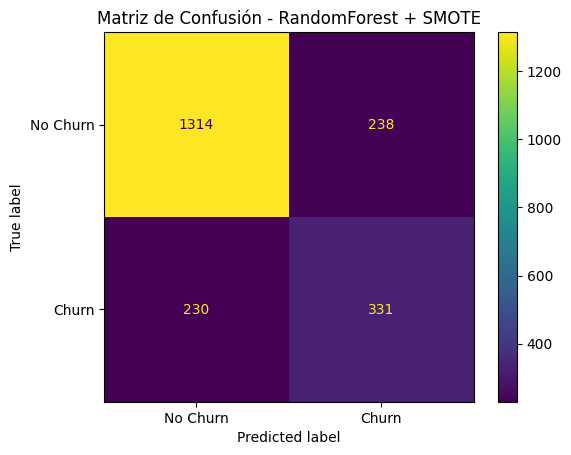


Resumen Estratégico:
Clientes que se iban y fueron detectados (TP): 331
Clientes que se iban y NO fueron detectados (FN): 230

MODELO: RandomForest + Undersampling

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.73      0.81      1552
         1.0       0.51      0.78      0.62       561

    accuracy                           0.74      2113
   macro avg       0.71      0.76      0.71      2113
weighted avg       0.80      0.74      0.76      2113

ROC-AUC: 0.8366


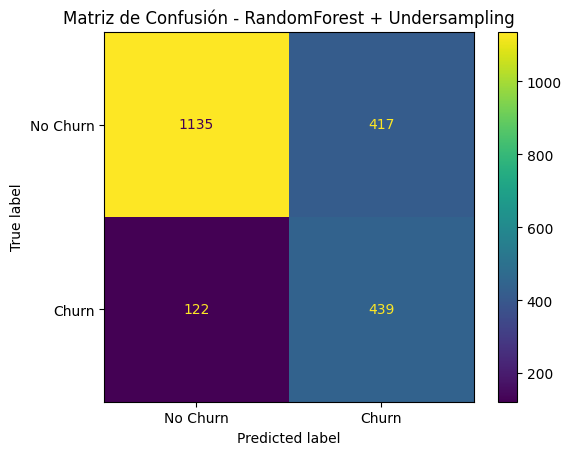


Resumen Estratégico:
Clientes que se iban y fueron detectados (TP): 439
Clientes que se iban y NO fueron detectados (FN): 122


,modelo,recall_churn,precision_churn,roc_auc
3,RandomForest + Undersampling,0.782531,0.512850,0.836620
1,KNN + Undersampling,0.771836,0.463102,0.784208
0,KNN + SMOTE,0.696970,0.443814,0.754466
2,RandomForest + SMOTE,0.590018,0.581722,0.833606


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

resultados = []

resultados.append(
    evaluar_modelo(modelo_knn, X_train_over, y_train_over, X_test, y_test, "KNN + SMOTE")
)

resultados.append(
    evaluar_modelo(modelo_knn, X_train_under, y_train_under, X_test, y_test, "KNN + Undersampling")
)

resultados.append(
    evaluar_modelo(modelo_rf, X_train_over, y_train_over, X_test, y_test, "RandomForest + SMOTE")
)

resultados.append(
    evaluar_modelo(modelo_rf, X_train_under, y_train_under, X_test, y_test, "RandomForest + Undersampling")
)

benchmark_df = pd.DataFrame(resultados)
display(benchmark_df.sort_values(by="recall_churn", ascending=False))

## 📋 Interpretación y Conclusiones

### Análisis de la Importancia de las Variables

Después de elegir los modelos, realiza el análisis de las variables más relevantes para la predicción de la cancelación:

* Regresión Logística: Investiga los coeficientes de las variables, que muestran su contribución a la predicción de cancelación.
* KNN (K-Nearest Neighbors): Observa cómo los vecinos más cercanos influyen en la decisión de clasificación. Las variables más impactantes pueden ser aquellas que más contribuyen a la proximidad entre los puntos de datos.
* Random Forest: Utiliza la importancia de las variables proporcionada por el modelo. Random Forest calcula la importancia basándose en cómo cada variable contribuye a la reducción de la impureza durante las divisiones de los árboles.
* SVM (Support Vector Machine): En el SVM, las variables más relevantes son aquellas que influyen en la frontera de decisión entre las clases. Puedes analizar los coeficientes de los vectores de soporte para entender qué variables tienen mayor impacto.
* Otros Modelos: Dependiendo del modelo elegido, considera el análisis de métricas específicas para comprender la relevancia de las variables. Por ejemplo, coeficientes en modelos lineales, pesos en redes neuronales, o la importancia relativa en técnicas de boosting (como XGBoost).



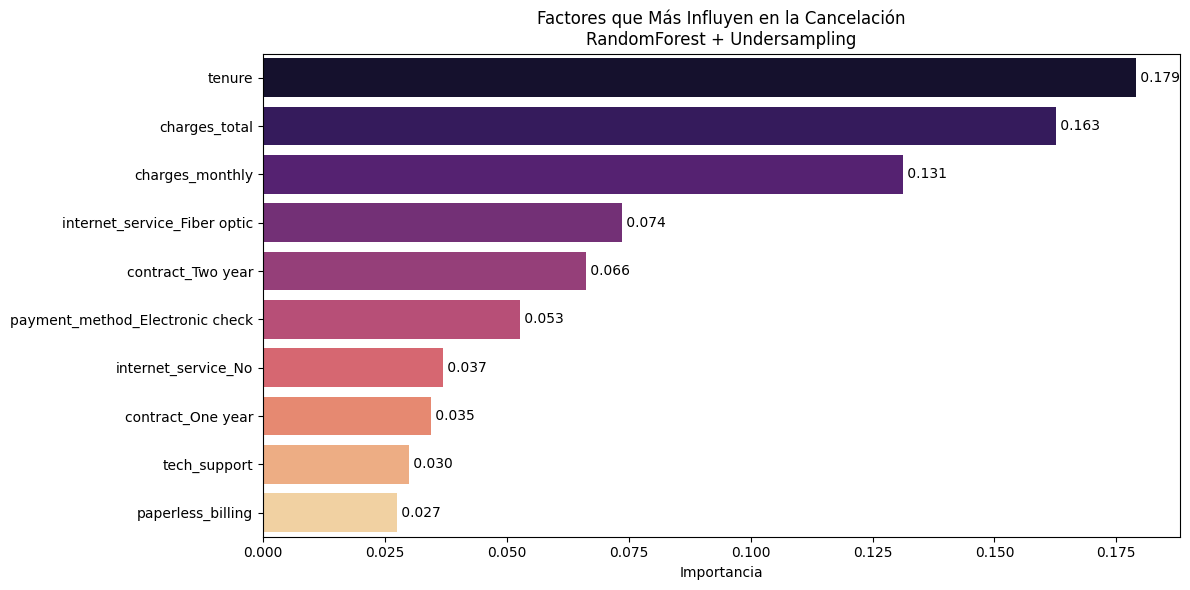

In [ ]:
modelo_rf.fit(X_train_under, y_train_under)

importancias = modelo_rf.feature_importances_
feature_names = X_train_under.columns

feature_importance_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importancias
    })
    .sort_values(by="importance", ascending=False)
)

top_n = 10
feature_importance_top = feature_importance_df.head(top_n).copy()

feature_importance_top["feature"] = (
    feature_importance_top["feature"]
    .str.replace("cat__", "", regex=False)
    .str.replace("remainder__", "", regex=False)
)

plt.figure(figsize=(12, 6))

ax = sns.barplot(
    data=feature_importance_top,
    x="importance",
    y="feature",
    hue="feature",
    palette="magma",
    legend=False
)

for i, v in enumerate(feature_importance_top["importance"]):
    ax.text(v, i, f" {v:.3f}", va="center")

plt.title("Factores que Más Influyen en la Cancelación\nRandomForest + Undersampling")
plt.xlabel("Importancia")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [ ]:
feature_importance_top

,feature,importance
11,tenure,0.179091
22,charges_total,0.162645
21,charges_monthly,0.131282
0,internet_service_Fiber optic,0.073726
3,contract_Two year,0.066349
5,payment_method_Electronic check,0.052678
1,internet_service_No,0.037024
2,contract_One year,0.034546
17,tech_support,0.029978
20,paperless_billing,0.027467


### Exportando el modelo

In [75]:
import pickle

filename = 'champion.pkl'

with open(filename, 'wb') as file:
    pickle.dump(modelo_rf, file)

print(f"¡Éxito! El modelo ha sido exportado como: {filename}")

¡Éxito! El modelo ha sido exportado como: champion.pkl


# Conclusión: Predicción de Cancelación de Clientes (Churn) - Telecom X

## 1. Resumen del Problema de Negocio
Telecom X enfrenta una tasa de cancelación del **27%**, lo que implica que aproximadamente 1 de cada 4 clientes abandona la compañía. El análisis exploratorio permitió identificar que la cancelación no es un fenómeno aleatorio, sino que está fuertemente asociada al ciclo de vida del cliente, la estructura económica del servicio y el nivel de compromiso contractual.

Las variables críticas identificadas fueron:
* **Baja antigüedad (tenure):** El riesgo es máximo en los primeros meses.
* **Estructura de Contrato:** Predominancia de churn en contratos mensuales.
* **Carga Económica:** Altos cargos mensuales con bajo gasto acumulado (clientes nuevos con planes caros).
* **Tecnología y Pagos:** Uso de Fibra Óptica y métodos de pago manuales (*Electronic Check*).
* **Falta de Ecosistema:** Ausencia de servicios de valor agregado (seguridad, soporte técnico).

## 2. Metodología y Construcción del Pipeline
Para abordar el desafío, se diseñó un pipeline robusto que garantizara la integridad y escalabilidad de los resultados:
1.  **Codificación:** Uso de `OneHotEncoding` para variables multiclase y estandarización de booleanas.
2.  **Tratamiento de Desbalance:** Aplicación de técnicas de **Undersampling** y **SMOTE** para mitigar el sesgo del 73/27 en la proporción de clases.
3.  **Evaluación Cruzada:** Implementación de `StratifiedKFold` para asegurar que el rendimiento del modelo fuera estable y no fruto del azar.
4.  **Selección de Modelos:** Comparativa entre KNN, Árboles de Decisión y Random Forest.

## 3. Rendimiento de los Modelos y Selección
Se priorizó el **Recall** (Sensibilidad) sobre otras métricas, ya que para Telecom X el costo de omitir una fuga (Falso Negativo) es significativamente mayor al costo de una acción de retención preventiva.

| Modelo | Recall (Churn) | ROC-AUC | Estado |
| :--- | :--- | :--- | :--- |
| KNN + Undersampling | 77.1% | 0.784 | Finalista |
| **RandomForest + Undersampling** | **78.2%** | **0.836** | **GANADOR** |

**Justificación:** El modelo **RandomForest + Undersampling** fue seleccionado como la solución definitiva. Logró identificar correctamente a **439 de los 561 clientes** en riesgo en el set de prueba, manteniendo el ROC-AUC más alto (0.836), lo que garantiza una excelente capacidad de discriminación entre clases.

## 4. Factores Clave en la Cancelación (Insights del Modelo)
Basándonos en la importancia de variables del Random Forest, los principales determinantes son:

* **A. El Factor Tiempo (tenure – 0.179):** Es la variable más influyente. El churn es principalmente un fenómeno de clientes nuevos. Una vez superado el umbral de los 6-12 meses, la lealtad se incrementa notablemente.
* **B. El Factor Económico (0.293 combinado):** La combinación de `charges_monthly` alto y `charges_total` bajo define el perfil de máximo riesgo. El cliente percibe un costo elevado antes de experimentar el valor a largo plazo del servicio. Existe un desalineamiento temporal entre percepción de costo y percepción de valor.
* **C. Barreras Contractuales:** El modelo confirma que los contratos de 1 y 2 años actúan como anclas de permanencia efectivas.
* **D. Fricción en Pagos y Tecnología:** Los pagos manuales aumentan la probabilidad de baja al generar un punto de decisión mensual para el cliente, mientras que la Fibra Óptica presenta una sensibilidad mayor, posiblemente por expectativas de servicio no cumplidas.

## 5. Estrategias de Retención Propuestas
1.  **Programa de Onboarding Intensivo:** Seguimiento proactivo durante los primeros 6 meses para proteger la inversión de adquisición (CAC).
2.  **Incentivos de Migración Contractual:** Campañas para convertir contratos mensuales a anuales mediante beneficios en servicios adicionales.
3.  **Paquetización de Valor (Bundling):** Promover `Tech Support` y `Online Security` en planes de Fibra Óptica para aumentar el costo de cambio percibido por el cliente.
4.  **Automatización de Pagos:** Ofrecer bonificaciones por migrar de *Electronic Check* a débito automático, eliminando la fricción de pago mensual.

## 6. Impacto Estratégico y Próximos Pasos
Con este modelo, Telecom X deja de ser reactiva y pasa a una **estrategia predictiva**, logrando identificar correctamente el **78% de los clientes que efectivamente cancelan (Recall)**.

**Próximos pasos sugeridos:**
* Ajuste fino de hiperparámetros para optimizar la precisión.
* Integración del modelo en el CRM para alertas en tiempo real.
* Uso de análisis de explicabilidad (SHAP) para personalizar los argumentos de retención según el perfil de cada cliente.

El churn deja de ser una métrica histórica y se convierte en una variable gestionable mediante analítica predictiva.